# Tweet Sentiment Analysis
---

In [346]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import json

#Import WordCloud
from wordcloud import WordCloud, STOPWORDS
from scipy import stats

In [347]:
# Remove unwanted patterns
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from bs4 import BeautifulSoup

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tywang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/tywang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [348]:
#Model Selection and Validation
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

#from sklearn.cross_validation import StratifiedKFold, KFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold, learning_curve

In [349]:
# Tweet Cleaner
stopwordlist = set(stopwords.words("english"))
wordnet_lemmatizer = WordNetLemmatizer()
ps = PorterStemmer()

with open('ShortendText.json','r') as file:
    slang_dict=json.loads(file.read())

def remove_stopwords(tweet):
    new_tweet = [w for w in tweet.split() if not w in stopwordlist] 
    return (" ").join(new_tweet) 

def remove_specialchar(tweet):
    #Converts HTML tags to the characters they represent
    soup = BeautifulSoup(tweet, "html.parser")
    tweet = soup.get_text()
    
    #Convert www.* or https?://* to empty strings
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',tweet) 
    #Convert @username to empty strings
    tweet = re.sub('@[^\s]+','',tweet)

    #Remove additional white spaces
    tweet = re.sub('[\s]+', ' ', tweet)
    tweet = re.sub('[\n]+', ' ', tweet)
    
    #Replace #word with word
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
    
    #Trims the tweet
    tweet = tweet.strip('\'"')
    
    #Remove all char not alphabets, num or whitespaces
    tweet = re.sub('[^A-Za-z ]+','', tweet)
    
    return tweet


#Attempts to replace every individual word with it's root word.
def stemmer_lemmatizer(tweet):
    word_list = []
    for word in tweet.split():
        word = ps.stem(word)
        word = wordnet_lemmatizer.lemmatize(word)
        word_list.append(word)
    return (" ".join(word_list))

#for testing
#Tweets = df_oba['Tweet'].values
#for i in range(len(Tweets)):
#    print(i)
#    b = remove_specialchar(Tweets[i])
#    a = stemmer_lemmatizer(b)
#    print('last', a)
#    print('last', remove_stopwords(a))

def lookup_dict(text, dictionary):
    for word in text.split():
        if word.lower() in dictionary:
            if word.lower() in text.split():
                text = text.replace(word, dictionary[word.lower()])
    return text

In [350]:
abbr_dict={
    "what's":"what is",
    "what're":"what are",
    "who's":"who is",
    "who're":"who are",
    "where's":"where is",
    "where're":"where are",
    "when's":"when is",
    "when're":"when are",
    "how's":"how is",
    "how're":"how are",

    "i'm":"i am",
    "we're":"we are",
    "you're":"you are",
    "they're":"they are",
    "it's":"it is",
    "he's":"he is",
    "she's":"she is",
    "that's":"that is",
    "there's":"there is",
    "there're":"there are",
    
    "i've":"i have",
    "we've":"we have",
    "you've":"you have",
    "they've":"they have",
    "who've":"who have",
    "would've":"would have",
    "not've":"not have",

    "i'll":"i will",
    "we'll":"we will",
    "you'll":"you will",
    "he'll":"he will",
    "she'll":"she will",
    "it'll":"it will",
    "they'll":"they will",

    "isn't":"is not",
    "wasn't":"was not",
    "aren't":"are not",
    "weren't":"were not",
    "can't":"can not",
    "couldn't":"could not",
    "don't":"do not",
    "didn't":"did not",
    "shouldn't":"should not",
    "wouldn't":"would not",
    "doesn't":"does not",
    "haven't":"have not",
    "hasn't":"has not",
    "hadn't":"had not",
    "won't":"will not",
    #punctuation:'',
    '\s+':' ', # replace multi space with one single space
}

In [351]:
def load_csv():
    xls = pd.ExcelFile('/Users/tywang/XCODEproject/CS583/CS583_ResearchProject/training-Obama-Romney-tweets.xlsx')
    df1 = pd.read_excel(xls, 'Obama')
    df2 = pd.read_excel(xls, 'Romney')
    return df1, df2

def data_parse(df):
    
    #drop missing values and rename columns
    df = df.iloc[1:, 3:5]
    df = df.rename(columns = {'Anootated tweet':'Tweet', 'Unnamed: 4': 'Class'})
    # Drop rows if Tweet is empty
    df.dropna(subset = ['Tweet'], inplace=True)
    print(df.shape)
    
    #dtype class label
    df['Class'] = df['Class'].astype(str)
    df['Tweet'] = df['Tweet'].astype(str)
    print(df.info())
    print(df['Class'].value_counts())

    # Extract rows where class labels -1, 0, 1
    df = df[ (df['Class'] == '0') |(df['Class'] == '-1') | (df['Class'] == '1') ]
    print('After extracting:', df.shape)
    
    tweets = df['Tweet'].values
    targets = df['Class'].values
    
    return tweets, targets

def tweet_cleaning(tweets, flag):
    
    for i in range(len(tweets)):
        #print(i)
        #print('original:', tweets[i])
        tweets[i] = tweets[i].lower()
        # if tweets[i] in slang_dict.keys():
        #    tweets[i].replace(slang_dict,regex=True,inplace=True)
        # if tweets[i] in abbr_dict.keys():
        #    tweets[i].replace(abbr_dict,regex=True,inplace=True)
        
        #tweets[i] = ' '.join(filter(lambda x: x.isalpha(), ''.join(tweets[i])))
        tweets[i] = remove_specialchar(tweets[i])
        if flag == 'stem_lem':
            tweets[i] = stemmer_lemmatizer(tweets[i])
        if flag == 'rm_stopwords':
            tweets[i] = remove_stopwords(tweets[i])
        if flag == 'all':
            tmp = remove_specialchar(tweets[i])
            tmp = stemmer_lemmatizer(tmp)
            tweets[i] = remove_stopwords(tmp)
        #tmp = remove_specialchar(tweets[i])
        #tmp = stemmer_lemmatizer(tmp)
        #tweets[i] = remove_stopwords(tmp)
        #print('final:', tweets[i])
    return tweets

In [352]:
# tweets_oba[10]

In [353]:
def save_dataset(tweets, targets, tw_name, tar_name):
    print('Saving training dataset...')
    
    #Create Saving Files
    if not os.path.exists('/Users/tywang/XCODEproject/CS583/CS583_ResearchProject/TrainData'):
        os.makedirs('/Users/tywang/XCODEproject/CS583/CS583_ResearchProject/TrainData')
        
    np.save('/Users/tywang/XCODEproject/CS583/CS583_ResearchProject/TrainData/' + tw_name + '.npy', tweets)
    np.save('/Users/tywang/XCODEproject/CS583/CS583_ResearchProject/TrainData/' + tar_name + '.npy', targets)

    print('Saved parsed dataset')
    

In [354]:
def wordcloud(data,backgroundcolor = 'white', width = 400, height = 150):
    wordcloud = WordCloud(stopwords = STOPWORDS, background_color = backgroundcolor,
                         width = width, height = height).generate(data)
    plt.figure(figsize = (15, 10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

In [355]:
df1, df2 = load_csv()

## Obama's Tweets

In [356]:

tweets_oba, targets_oba = data_parse(df1)
tweets_oba.shape, targets_oba.shape

(7196, 2)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7196 entries, 1 to 7198
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tweet   7196 non-null   object
 1   Class   7196 non-null   object
dtypes: object(2)
memory usage: 168.7+ KB
None
0             1977
-1            1968
1             1679
2             1543
irrevelant      23
nan              5
irrelevant       1
Name: Class, dtype: int64
After extracting: (5624, 2)


((5624,), (5624,))

In [357]:
#Apply Custom Dictionary
tweets_oba
df_oba = pd.DataFrame({'tweet':tweets_oba,'label':targets_oba})
df_oba['tweet'] = df_oba['tweet'].apply(lambda x: lookup_dict(x,slang_dict))
df_oba['tweet'] = df_oba['tweet'].apply(lambda x: lookup_dict(x,abbr_dict))
df_oba.to_csv('/Users/tywang/XCODEproject/CS583/CS583_ResearchProject/TrainData/parsed_tweets_oba.csv')
tweets_oba = df_oba['tweet']

## WordCloud for Oba_Tweet

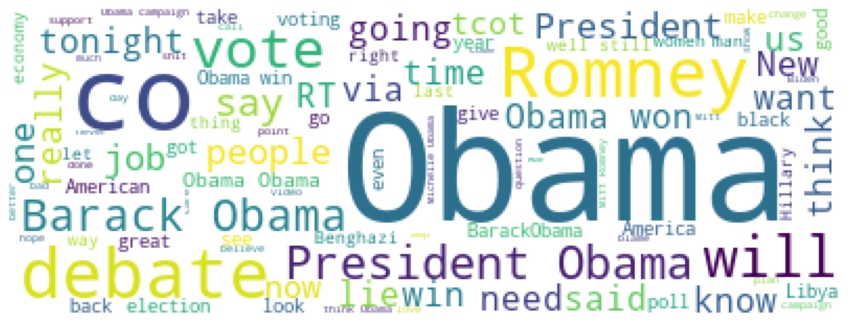

In [358]:
#Original Tweet
wordcloud(''.join(tweets_oba))

0       kirkpatrick who wore a baseball cap embroidere...
1       obama debates that cracker ass cracker tonight...
2        youre missing the point im afraid you do not ...
3       i was raised as a democrat left the party year...
4       the obama camp can not afford to lower expecta...
                              ...                        
5619     except for women who work in the wh they make...
5620      days to election  selection elect lewis ken ...
5621     the reason ann romney and michelle obama matc...
5622             obama kenakan cincin syahadat sejak sma 
5623     bitches be like obama bitches just want food ...
Name: tweet, Length: 5624, dtype: object


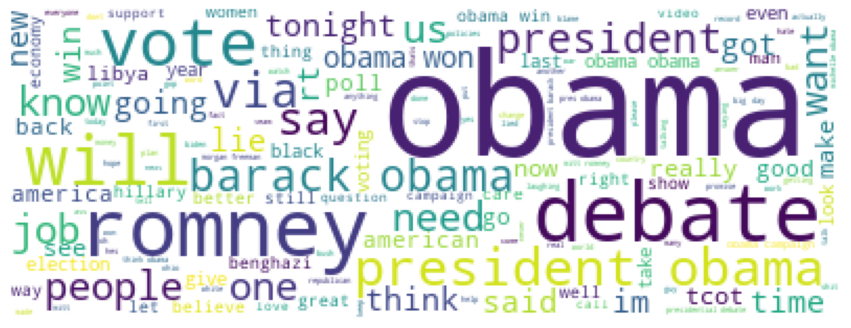

In [359]:
# Remove special char only
oba_rmspecial = tweet_cleaning(tweets_oba, '')
print(oba_rmspecial)
wordcloud(''.join(oba_rmspecial))

0       kirkpatrick who wore a basebal cap embroid wit...
1       obama debat that cracker as cracker tonight i ...
2       your miss the point im afraid you do not under...
3       i wa rais a a democrat left the parti year ago...
4       the obama camp can not afford to lower expect ...
                              ...                        
5619    except for woman who work in the wh they make ...
5620    day to elect select elect lewi ken hall mha na...
5621    the reason ann romney and michel obama match l...
5622              obama kenakan cincin syahadat sejak sma
5623    bitch be like obama bitch just want food stamp...
Name: tweet, Length: 5624, dtype: object


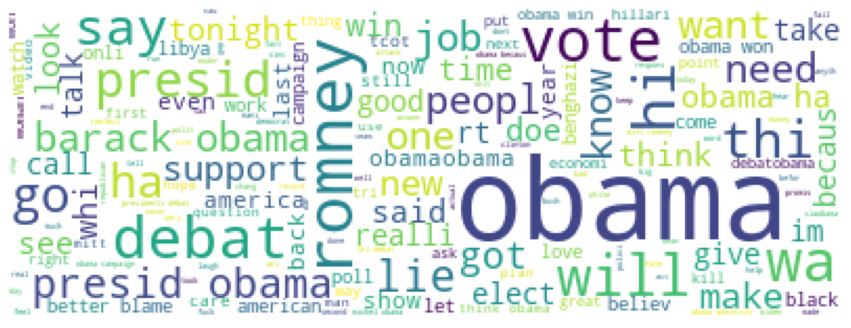

In [360]:
# Tweet stemmer_lemmatizer
oba_stemlem = tweet_cleaning(tweets_oba, 'stem_lem')
print(oba_stemlem)
wordcloud(''.join(oba_stemlem))

0       kirkpatrick wore basebal cap embroid barack ob...
1       obama debat cracker cracker tonight tune teamo...
2       miss point im afraid understand bigger pictur ...
3       wa rais democrat left parti year ago lifetim n...
4       obama camp afford lower expect tonight debat p...
                              ...                        
5619    except woman work wh make le honest yup obama ...
5620    day elect select elect lewi ken hall mha natio...
5621    reason ann romney michel obama match last nigh...
5622              obama kenakan cincin syahadat sejak sma
5623         bitch like obama bitch want food stamp laugh
Name: tweet, Length: 5624, dtype: object


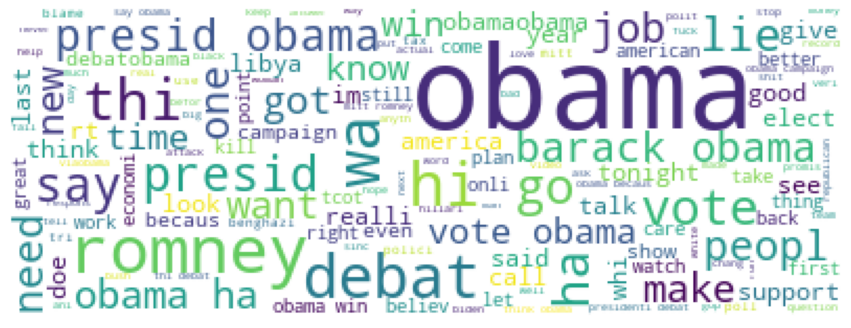

In [361]:
# Remove stopword
oba_rmstop = tweet_cleaning(tweets_oba, 'rm_stopwords')
print(oba_rmstop)
wordcloud(''.join(oba_rmstop))

0       kirkpatrick wore baseb cap embroid barack obam...
1       obama debat cracker cracker tonight tune teamo...
2       miss point im afraid understand bigger pictur ...
3       wa rai democrat left parti year ago lifetim ne...
4       obama camp afford lower expect tonight debat p...
                              ...                        
5619    except woman work wh make le honest yup obama ...
5620    day elect select elect lewi ken hall mha natio...
5621    reason ann romney michel obama match last nigh...
5622              obama kenakan cincin syahadat sejak sma
5623         bitch like obama bitch want food stamp laugh
Name: tweet, Length: 5624, dtype: object


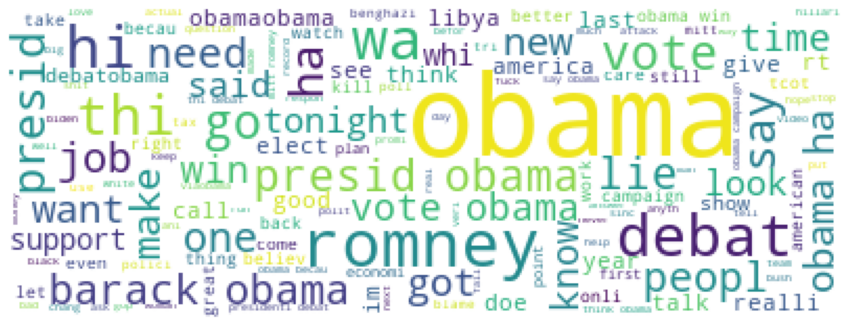

In [362]:
# All cleaning methods
oba_cleanall = tweet_cleaning(tweets_oba, 'all')
print(oba_cleanall)
wordcloud(''.join(oba_cleanall))

In [363]:
save_dataset(oba_cleanall, targets_oba, 'tweets_oba', 'targets_oba')

Saving training dataset...
Saved parsed dataset


## Romney's Tweets

In [364]:
tweets_rom, targets_rom = data_parse(df2)
tweets_rom.shape, targets_rom.shape

(7200, 2)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7200 entries, 1 to 7200
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tweet   7200 non-null   object
 1   Class   7200 non-null   object
dtypes: object(2)
memory usage: 168.8+ KB
None
-1      2893
0       1680
2       1351
1       1075
!!!!     169
nan       29
IR         3
Name: Class, dtype: int64
After extracting: (5648, 2)


((5648,), (5648,))

In [365]:
tweets_rom
df_rom = pd.DataFrame({'tweet':tweets_rom,'label':targets_rom})
df_rom['tweet'] = df_rom['tweet'].apply(lambda x: lookup_dict(x,slang_dict))
df_rom['tweet'] = df_rom['tweet'].apply(lambda x: lookup_dict(x,abbr_dict))
df_rom.to_csv('/Users/tywang/XCODEproject/CS583/CS583_ResearchProject/TrainData/parsed_tweets_rom.csv')
tweets_rom = df_rom['tweet']

## WordCloud for Rom_tweet

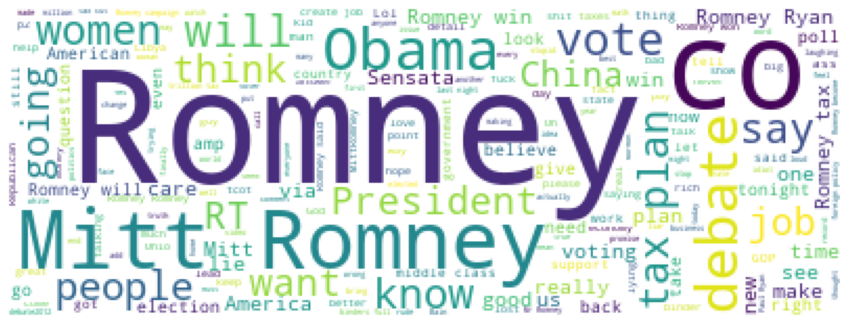

In [366]:
wordcloud(' '.join(tweets_rom))

0       insidiousmitt romneys bain helped philip morri...
1                 you mean like romney cheated in primary
2       mitt romney still does not believe that we hav...
3       romneys tax plan deserves a nd look because he...
4       hope romney debate prepped with the same peopl...
                              ...                        
5643    washington reuters  with polls suggesting wome...
5644    cnns john king after two debates romney still ...
5645    el  por ciento de las mujeres blancas casadas ...
5646    and they brought us a whole binder of women oh...
5647                                            romneywon
Name: tweet, Length: 5648, dtype: object


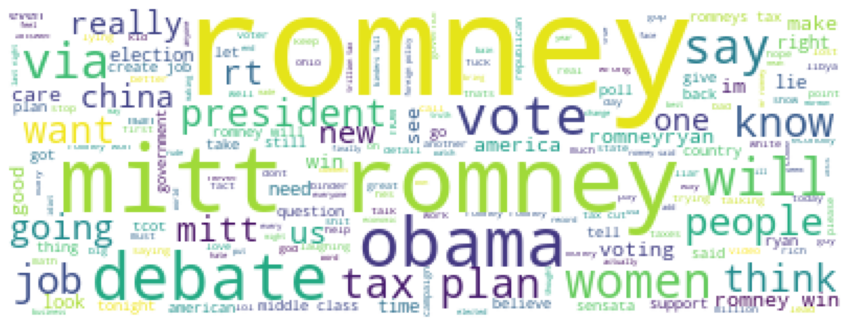

In [367]:
# Remove special char only
rom_rmspecial = tweet_cleaning(tweets_rom, '')
print(rom_rmspecial)
wordcloud(''.join(rom_rmspecial))

0       insidiousmitt romney bain help philip morri ge...
1                   you mean like romney cheat in primari
2       mitt romney still doe not believ that we have ...
3       romney tax plan deserv a nd look becaus he ha ...
4       hope romney debat prep with the same peopl a l...
                              ...                        
5643    washington reuter with poll suggest woman vote...
5644    cnn john king after two debat romney still ha ...
5645    el por ciento de la mujer blanca casada respal...
5646    and they brought u a whole binder of woman oh ...
5647                                            romneywon
Name: tweet, Length: 5648, dtype: object


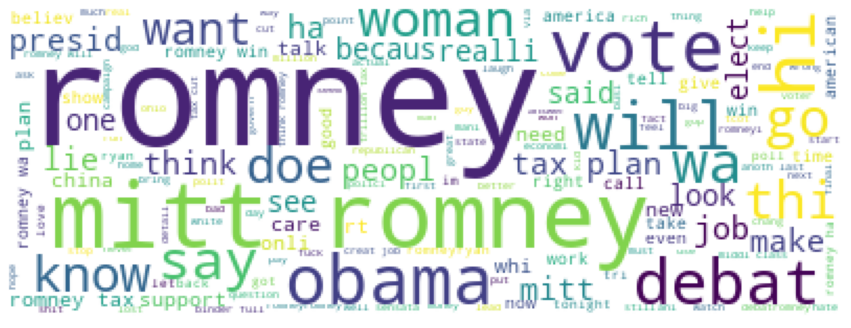

In [368]:
# Tweet stemmer_lemmatizer
rom_stemlem = tweet_cleaning(tweets_rom, 'stem_lem')
print(rom_stemlem)
wordcloud(''.join(rom_stemlem))

0       insidiousmitt romney bain help philip morri ge...
1                          mean like romney cheat primari
2               mitt romney still doe believ black presid
3       romney tax plan deserv nd look becaus ha secre...
4                  hope romney debat prep peopl last time
                              ...                        
5643    washington reuter poll suggest woman voter shi...
5644    cnn john king two debat romney still ha plu pr...
5645    el por ciento de la mujer blanca casada respal...
5646               brought u whole binder woman oh romney
5647                                            romneywon
Name: tweet, Length: 5648, dtype: object


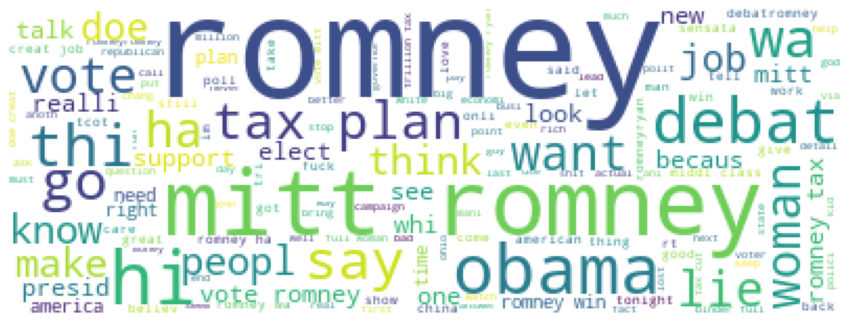

In [369]:
# Remove stopword
rom_rmstop = tweet_cleaning(tweets_rom, 'rm_stopwords')
print(rom_rmstop)
wordcloud(''.join(rom_rmstop))

0       insidiousmitt romney bain help philip morri ge...
1                          mean like romney cheat primari
2               mitt romney still doe believ black presid
3       romney tax plan deserv nd look becau ha secret...
4                  hope romney debat prep peopl last time
                              ...                        
5643    washington reuter poll suggest woman voter shi...
5644    cnn john king two debat romney still ha plu pr...
5645    el por ciento de la mujer blanca casada respal...
5646               brought u whole binder woman oh romney
5647                                            romneywon
Name: tweet, Length: 5648, dtype: object


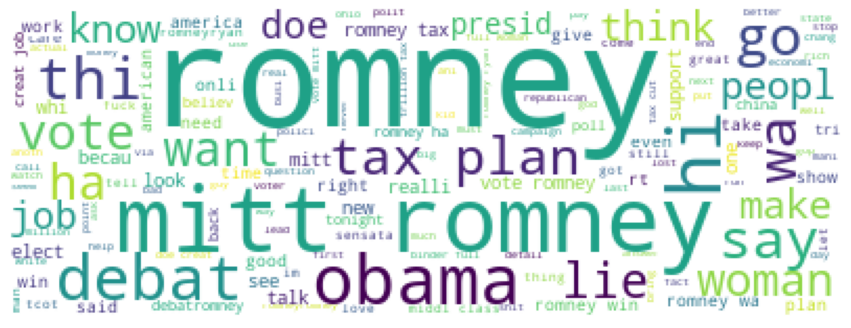

In [370]:
# All cleaning methods
rom_cleanall = tweet_cleaning(tweets_rom, 'all')
print(rom_cleanall)
wordcloud(''.join(rom_cleanall))

In [371]:
save_dataset(rom_cleanall, targets_rom, 'tweets_rom', 'targets_rom')

Saving training dataset...
Saved parsed dataset


### Data Info

In [372]:
import seaborn as sns
df = pd.DataFrame({'tweet':oba_cleanall, 'label': targets_oba })

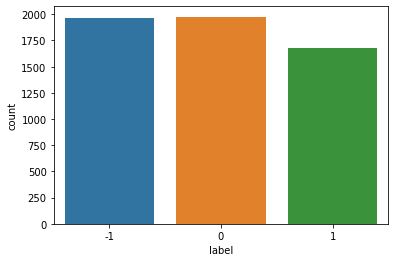

In [373]:
sns.countplot(df['label'])

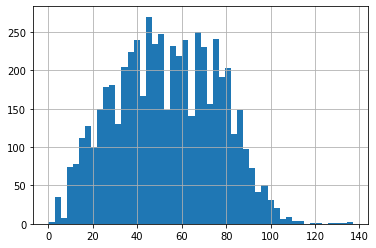

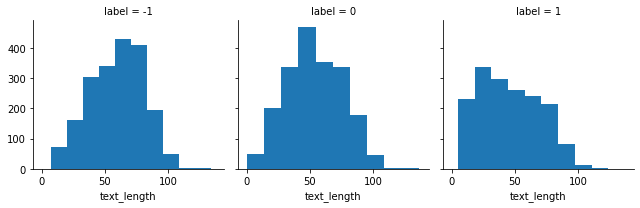

In [374]:
df['text_length'] = df['tweet'].apply(len)
df[['label','text_length','tweet']].head()
df['text_length'].describe()
df['text_length'].hist(bins=50)
g = sns.FacetGrid(df,col='label')
g.map(plt.hist,'text_length')

## Data Vectorization

In [375]:
train_X, test_X, train_Y, test_Y = train_test_split(oba_cleanall, targets_oba, test_size = 0.2, random_state = 42)

### TF-IDF vectorizer

In [376]:
#tfv = TfidfVectorizer(smooth_idf=False, sublinear_tf=False, norm=None, analyzer='word')
tfv = TfidfVectorizer()
train_tfv = tfv.fit_transform(train_X)
test_tfv = tfv.transform(test_X)

In [377]:
vocab = tfv.get_feature_names()
print(vocab[:5])
print("Vocabulary length:", len(vocab))
dist = np.sum(train_tfv, axis=0)
checking = pd.DataFrame(dist, columns = vocab)
checking

['aa', 'aaaand', 'aabout', 'aand', 'aandd']
Vocabulary length: 6231


,aa,aaaand,aabout,aand,aandd,aandgri,aandswer,aandymor,aandyoand,aar,...,zerohedg,zesti,zien,zinger,zippedexcept,zipper,zombi,zwei,zzz,zzzzzzzzzz
0,0.423518,0.492108,0.332049,0.403585,1.521574,0.297258,0.605377,0.318355,0.262403,0.513029,...,0.481233,0.57943,0.262941,0.445126,0.392438,0.369258,0.915296,0.353361,0.586504,0.992809


In [378]:
tfv.idf_

array([8.7186855, 8.7186855, 8.7186855, ..., 8.7186855, 8.7186855,
       8.7186855])

### Count Vector

In [379]:
cv = CountVectorizer()
train_cv = cv.fit_transform(train_X)
test_cv = cv.transform(test_X)

In [380]:
cvocab = cv.get_feature_names()
print(cvocab[:5])

['aa', 'aaaand', 'aabout', 'aand', 'aandd']


### Train Models

##### MLP Classifier

In [381]:
MLP = MLPClassifier(random_state = 42)

mlp_param_grid = {
    'hidden_layer_sizes':[(5)],
    'activation':['relu'],
    'solver':['adam'],
    'alpha':[0.3],
    'learning_rate':['constant'],
    'max_iter':[1000]
}

kfold = StratifiedKFold( n_splits = 5, random_state = 42, shuffle=True )
gsMLP = GridSearchCV(MLP, param_grid = mlp_param_grid, cv = kfold, n_jobs= 1, verbose = 1)
gsMLP.fit(train_tfv, train_Y)
print(gsMLP.best_params_)
mlp_best0 = gsMLP.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits
{'activation': 'relu', 'alpha': 0.3, 'hidden_layer_sizes': 5, 'learning_rate': 'constant', 'max_iter': 1000, 'solver': 'adam'}


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   34.8s finished


In [382]:
gsMLP.best_score_
MLP_Y_predict = gsMLP.predict(test_tfv)
print("MLP Classifier - Training Result")
print(classification_report(gsMLP.predict(train_tfv),train_Y,digits=4))
print("MLP Classifier - Validation Result")
print(classification_report(MLP_Y_predict,test_Y, digits=4))


MLP Classifier - Training Result
              precision    recall  f1-score   support

          -1     0.9703    0.9715    0.9709      1578
           0     0.9558    0.9699    0.9628      1562
           1     0.9678    0.9500    0.9588      1359

    accuracy                         0.9644      4499
   macro avg     0.9646    0.9638    0.9642      4499
weighted avg     0.9645    0.9644    0.9644      4499

MLP Classifier - Validation Result
              precision    recall  f1-score   support

          -1     0.6469    0.5878    0.6160       427
           0     0.5077    0.5393    0.5230       369
           1     0.5594    0.5866    0.5727       329

    accuracy                         0.5716      1125
   macro avg     0.5713    0.5712    0.5705      1125
weighted avg     0.5756    0.5716    0.5728      1125



##### Logistic Regression

In [383]:
from sklearn import linear_model

logisticReg = linear_model.LogisticRegression(solver='lbfgs',class_weight='balanced', max_iter=10000)
logisticReg.fit(train_tfv, train_Y)

LogisticRegression(class_weight='balanced', max_iter=10000)

In [384]:
Y_predict=logisticReg.predict(test_tfv)

In [385]:
print("Logistic Regression - Training Result")
print(classification_report(logisticReg.predict(train_tfv),train_Y,digits=4))
print("Logistic Regression - Validation Result")
print(classification_report(Y_predict,test_Y, digits=4))

Logistic Regression - Training Result
              precision    recall  f1-score   support

          -1     0.8646    0.8463    0.8554      1614
           0     0.8132    0.8588    0.8354      1501
           1     0.8553    0.8244    0.8396      1384

    accuracy                         0.8437      4499
   macro avg     0.8444    0.8432    0.8434      4499
weighted avg     0.8446    0.8437    0.8438      4499

Logistic Regression - Validation Result
              precision    recall  f1-score   support

          -1     0.6211    0.5907    0.6055       408
           0     0.5281    0.5565    0.5419       372
           1     0.5971    0.5971    0.5971       345

    accuracy                         0.5813      1125
   macro avg     0.5821    0.5814    0.5815      1125
weighted avg     0.5830    0.5813    0.5819      1125



##### Linear Support Vector Classification

In [386]:
from sklearn import svm
clf = svm.LinearSVC(max_iter=2000)
clf.fit(train_tfv, train_Y)

LinearSVC(max_iter=2000)

In [387]:
clf_Y_predict = clf.predict(test_tfv)
print("Linear Support Vector Classification - Training Result")
print(classification_report(clf.predict(train_tfv),train_Y,digits=4))
print("Linear Support Vector Classification - Validation Result")
print(classification_report(clf_Y_predict,test_Y, digits=4))

Linear Support Vector Classification - Training Result
              precision    recall  f1-score   support

          -1     0.9595    0.9481    0.9538      1599
           0     0.9319    0.9535    0.9426      1549
           1     0.9430    0.9312    0.9371      1351

    accuracy                         0.9449      4499
   macro avg     0.9448    0.9443    0.9445      4499
weighted avg     0.9450    0.9449    0.9449      4499

Linear Support Vector Classification - Validation Result
              precision    recall  f1-score   support

          -1     0.6366    0.5785    0.6061       427
           0     0.5102    0.5348    0.5222       374
           1     0.5623    0.5988    0.5800       324

    accuracy                         0.5698      1125
   macro avg     0.5697    0.5707    0.5694      1125
weighted avg     0.5732    0.5698    0.5707      1125



##### Random Forest Classifier

In [388]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

model = RandomForestClassifier()
model.fit(train_tfv, train_Y)

y_pred = model.predict(test_tfv)

print("Training Accuracy :", model.score(train_tfv, train_Y))
print("Validation Accuracy :", model.score(test_tfv, test_Y))

# calculating the f1 score for the validation set
#print("F1 score :", f1_score(test_Y, y_pred))

# confusion matrix
cm = confusion_matrix(test_Y, y_pred)
print(cm)

print("Random Forest Classifier - Training Result")
print(classification_report(model.predict(train_tfv),train_Y,digits=4))

print("Random Forest Classifier - Validation Result")
print(classification_report(y_pred,test_Y, digits=4))

Training Accuracy : 0.9919982218270726
Validation Accuracy : 0.5733333333333334
[[212 102  74]
 [ 80 225  87]
 [ 41  96 208]]
Random Forest Classifier - Training Result
              precision    recall  f1-score   support

          -1     0.9962    0.9949    0.9956      1582
           0     0.9849    0.9936    0.9892      1571
           1     0.9955    0.9866    0.9910      1346

    accuracy                         0.9920      4499
   macro avg     0.9922    0.9917    0.9919      4499
weighted avg     0.9920    0.9920    0.9920      4499

Random Forest Classifier - Validation Result
              precision    recall  f1-score   support

          -1     0.5464    0.6366    0.5881       333
           0     0.5740    0.5319    0.5521       423
           1     0.6029    0.5637    0.5826       369

    accuracy                         0.5733      1125
   macro avg     0.5744    0.5774    0.5743      1125
weighted avg     0.5753    0.5733    0.5728      1125



##### Decision Tree Classifier

In [389]:
model = DecisionTreeClassifier()
model.fit(train_tfv, train_Y)

y_pred = model.predict(test_tfv)

print("Training Accuracy :", model.score(train_tfv, train_Y))
print("Validation Accuracy :", model.score(test_tfv, test_Y))

# calculating the f1 score for the validation set
#print("F1 score :", f1_score(test_Y, y_pred))

# confusion matrix
cm = confusion_matrix(test_Y, y_pred)
print(cm)

print("Training Result")
print(classification_report(model.predict(train_tfv), train_Y, digits=4))

print("Decision Tree Classifier")
print(classification_report(y_pred,test_Y, digits=4))

Training Accuracy : 0.9919982218270726
Validation Accuracy : 0.4622222222222222
[[172 128  88]
 [107 177 108]
 [ 78  96 171]]
Training Result
              precision    recall  f1-score   support

          -1     0.9981    0.9931    0.9956      1588
           0     0.9855    0.9930    0.9892      1573
           1     0.9925    0.9895    0.9910      1338

    accuracy                         0.9920      4499
   macro avg     0.9920    0.9919    0.9919      4499
weighted avg     0.9920    0.9920    0.9920      4499

Decision Tree Classifier
              precision    recall  f1-score   support

          -1     0.4433    0.4818    0.4617       357
           0     0.4515    0.4414    0.4464       401
           1     0.4957    0.4659    0.4803       367

    accuracy                         0.4622      1125
   macro avg     0.4635    0.4630    0.4628      1125
weighted avg     0.4633    0.4622    0.4623      1125



##### Linear Support Vector Classification

In [390]:
from sklearn.svm import SVC

model = SVC()
model.fit(train_tfv, train_Y)

y_pred = model.predict(test_tfv)

print("Training Accuracy :", model.score(train_tfv, train_Y))
print("Validation Accuracy :", model.score(test_tfv, test_Y))

# calculating the f1 score for the validation set
#print("F1 score :", f1_score(test_Y, y_pred))

# confusion matrix
cm = confusion_matrix(test_Y, y_pred)
print(cm)

Training Accuracy : 0.9599911091353635
Validation Accuracy : 0.6017777777777777
[[260  89  39]
 [112 229  51]
 [ 63  94 188]]


In [391]:
kfold = StratifiedKFold( n_splits = 5, random_state = 42, shuffle=True )
print(kfold)
sv = LinearSVC(random_state=2018)

param_grid2 = {
    'loss':['squared_hinge'],
    'class_weight':[{1:4}],
    'C': [0.2]
}
sv.fit(train_tfv, train_Y)
accuracy_score(test_Y, sv.predict(test_tfv))

StratifiedKFold(n_splits=5, random_state=42, shuffle=True)


0.5697777777777778

##### Gaussian Naive Bayes

In [392]:
from sklearn.naive_bayes import GaussianNB

pipeline = Pipeline([
    ('clf', GaussianNB())
])

parameters = {
    'clf__priors': [None],
    'clf__var_smoothing': [1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9]
}

cv = GridSearchCV(pipeline, param_grid=parameters, scoring='accuracy')

# gnb = GaussianNB()
Y_pred_Bayes = cv.fit(train_tfv.toarray(), train_Y).predict(test_tfv.toarray())
print(cv.best_params_)
print(cv.best_score_)
print("Gaussian Naive Bayes - Training Result")
print(classification_report(cv.predict(train_tfv.toarray()), train_Y, digits=4))
print("Gaussian Naive Bayes - Validation Result")
print(classification_report(Y_pred_Bayes,test_Y, digits=4))


{'clf__priors': None, 'clf__var_smoothing': 0.001}
0.4772114695340502
Gaussian Naive Bayes - Training Result
              precision    recall  f1-score   support

          -1     0.8576    0.9403    0.8971      1441
           0     0.7640    0.9878    0.8616      1226
           1     0.9985    0.7271    0.8414      1832

    accuracy                         0.8664      4499
   macro avg     0.8734    0.8851    0.8667      4499
weighted avg     0.8895    0.8664    0.8648      4499

Gaussian Naive Bayes - Validation Result
              precision    recall  f1-score   support

          -1     0.4974    0.5452    0.5202       354
           0     0.3265    0.4776    0.3879       268
           1     0.6551    0.4493    0.5330       503

    accuracy                         0.4862      1125
   macro avg     0.4930    0.4907    0.4804      1125
weighted avg     0.5272    0.4862    0.4944      1125

